In this notebook, we try to deduce the equivalent circuit of a WEST ICRH capacitor which has been simulated under HFSS.  

In [12]:
%matplotlib inline
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


First we import all the scattering parameters of the capacitor simulated at different positions. S-parameters are imported as `skrf` networks in a `NetworkSet` object. This `NetworkSet` will allow interpolating the capacitors are intermediate values of the $D_{cylinders}$ values, by interpolating the scattering parameters between individual Networks.

In [14]:
capas = rf.read_all('S_Matrices/', f_unit='MHz')
capas_set = rf.NetworkSet(capas)

f_band = '35-65MHz'

f = capas_set[0].f
omega = 2*np.pi*f
D_cylinders = [110, 100, 90, 80, 77, 76]
print(f'{len(capas)} s-parameter files representing {len(D_cylinders)} values of D_cyclinders')

6 s-parameter files representing 6 values of D_cyclinders


[None, None, None, None, None, None]

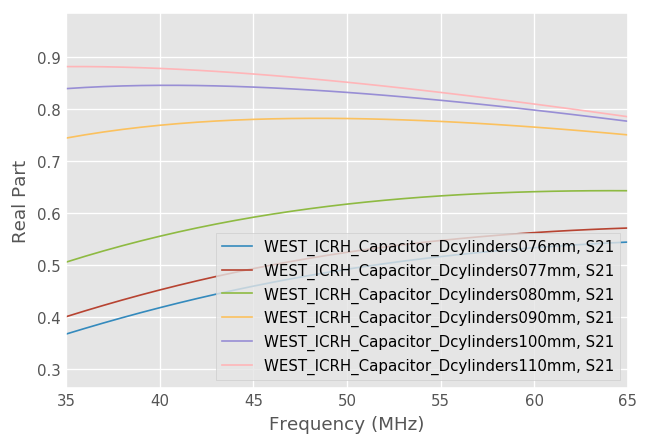

In [15]:
# check the data
capas_set[f_band].plot_s_re(m=1, n=0)

## Extracting the capacitance values

In [5]:
idx = (f > 40e6) & (f < 60e6)

### T impedance

Let's assume that the full-wave model can be compared to a T-network : 

![Star network](T.png)

which ABCD parameters are [Pozar, p.754]
$$
\mathbb{A}
=
\left(
\begin{matrix}
1 + \frac{Z_1}{Z_3} & Z_1 + Z_2 + \frac{Z_1 Z_2}{Z_3} \\
\frac{1}{Z_3} & 1 + \frac{Z_2}{Z_3}
\end{matrix}
\right)
$$

the purpose is now to fit assuming $Z_2=0$, $Z_1$ a resistor in serie with a capacitor and a self inductance, and $Z_3$ a shunt capacitance:
$$
\mathbb{A}_T
=
\left(
\begin{matrix}
1 + \frac{Z_1}{Z_3} & Z_1   \\
\frac{1}{Z_3} & 1
\end{matrix}
\right)
$$

In [41]:
# dummy transmission line to match port 3
coax = rf.media.Coaxial(frequency=capas_set[0].frequency)

In [158]:
def Z1(omega, R, C, L):
    '''
    Resistor R in series with a capacitance C and an inductance L
    R in Ohm, C in pF and L in nH
    '''
    return (R +1j*(- 1/(C*1e-12*omega) + L*1e-9*omega)) 

def Z1_re(omega, R, C, L):
    return np.real(Z1(omega, R, C, L))

def Z1_im(omega, R, C, L):
    return np.imag(Z1(omega, R, C, L))

def Z3(omega, Cshunt):
    'shung capacitance. C_shunt in pF'
    return -1j/(Cshunt*1e-12*omega)

def Z3_im(omega, Cshunt):
    return np.imag(Z3(omega, Cshunt))


In [159]:
Z1s, Z2s, Z3s = {}, {}, {}
Cs, Rs, Ls, C_shunts = [], [], [], []
# For each network in the network set, extract the equivalent network parameters
for (ntw_name, ntw) in capas.items():
    # connect the port 3 (voltage probe) to match load to make a 2-port network 
    # (since equivalent T network is only for a 2-ports network)
    ntw = rf.connect(ntw, 2, coax.match(), 0)
    # extract impedances
    Z3s[ntw_name] = 1/ntw.a[:,1,0]
    Z1s[ntw_name] = ntw.a[:,0,1]
    Z2s[ntw_name] = 0
    # fit the equivalent impedances values to the equivalent circuit elements R,l,Cs 
    (C_shunt,), cov = curve_fit(Z3_im, omega[idx], np.imag(Z3s[ntw_name][idx]))
    (_, C, L), cov = curve_fit(Z1_im, omega[idx], np.imag(Z1s[ntw_name][idx]))
    (R, _, _), cov = curve_fit(Z1_re, omega[idx], np.real(Z1s[ntw_name][idx]))
    
    print(f'{ntw_name}: C={C:.1f} pF, L={L:.1f} nH, C_shunt={C_shunt:.1f} pF, R={R:0.1e} Ohm')
    Cs.append(C)
    Rs.append(R)
    Ls.append(L)
    C_shunts.append(C_shunt)

WEST_ICRH_Capacitor_Dcylinders076mm: C=26.2 pF, L=36.7 nH, C_shunt=75.6 pF, R=1.0e-01 Ohm
WEST_ICRH_Capacitor_Dcylinders077mm: C=28.8 pF, L=36.2 nH, C_shunt=73.3 pF, R=8.7e-02 Ohm
WEST_ICRH_Capacitor_Dcylinders080mm: C=37.9 pF, L=35.2 nH, C_shunt=67.6 pF, R=5.3e-02 Ohm
WEST_ICRH_Capacitor_Dcylinders090mm: C=73.6 pF, L=34.3 nH, C_shunt=58.8 pF, R=1.9e-02 Ohm
WEST_ICRH_Capacitor_Dcylinders100mm: C=109.7 pF, L=34.7 nH, C_shunt=55.3 pF, R=1.2e-02 Ohm
WEST_ICRH_Capacitor_Dcylinders110mm: C=145.9 pF, L=35.6 nH, C_shunt=53.2 pF, R=1.0e-02 Ohm


Text(0, 0.5, 'Capacitance [pF]')

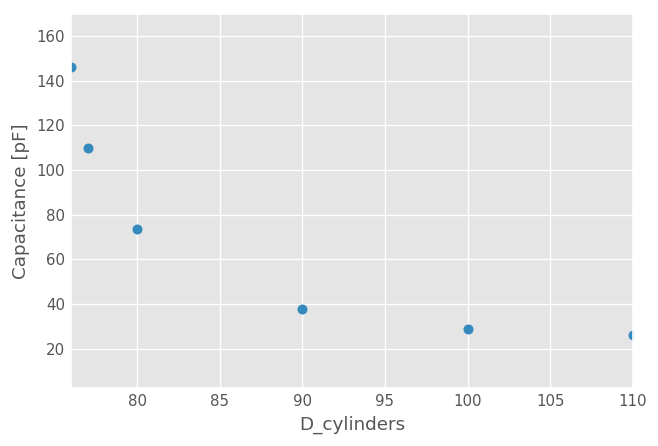

In [160]:
fig, ax = plt.subplots()
ax.plot(D_cylinders, Cs, '.', ms=10)
ax.set_xlabel('D_cylinders')
ax.set_ylabel('Capacitance [pF]')

The equivalent circuit parameters R,L can be set as constant:

In [161]:
R_eq = np.mean(Rs)
L_eq = np.mean(Ls)
C_shunt_eq = np.mean(C_shunts)

Now to test the performance of the equivalent model, we create a Network from the equivalent circuit and we compare S-parameter values to the ones of the NetworkSet :

In [169]:
def equivalent_capa_ntw(omega, C, R=R_eq, L=L_eq, C_shunt=C_shunt_eq):
    _Z1 = Z1(omega, R, C, L)
    _Z3 = Z3(omega, Cshunt=C_shunt)
    A11 = 1 + _Z1/_Z3
    A12 = _Z1
    A21 = 1/_Z3
    A22 = np.ones_like(omega)
    ntw = rf.Network()
    ntw.f_unit = 'Hz'
    ntw.f = omega/(2*np.pi)
    ntw.s = rf.a2s(np.array([[A11, A21], [A12, A22]]).T)
    return ntw

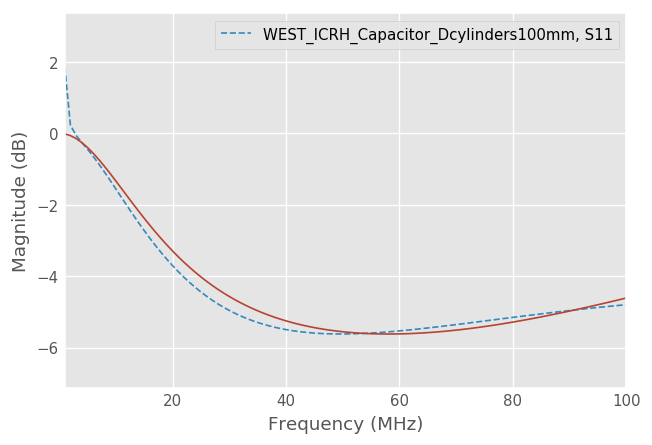

In [176]:
eq_capa = equivalent_capa_ntw(omega, C=100, C_shunt=50)

fig, ax = plt.subplots()
capas_set[-2].plot_s_db(m=0, n=0, ls='--', ax=ax)
ax.plot(omega/(2*np.pi), eq_capa.s_db[:,0,0])


## serie impedance

Reminding that the ABCD parameters of a serie impedance is (D. Pozar, Microwave Engineering Fourth Edition (Wiley, 2011), p.754, "The ABCD Parameters of Some Useful Two-Port Circuits."):

![Serie Impedance](serie_impedance.png)

$$
\left(
\begin{matrix}
1 & Z \\
0 & 1
\end{matrix}
\right)
$$

Assuming the impedance consist in a resistor, a self and a capacitor, then one can extract the element values of the network set from the ABCD parameter $Z=\textrm{ABCD}_{12}$: 
$$
Z \doteq R + j(L\omega - 1/C\omega)
$$

In [48]:
# L expressed in nH and C in pF to make the fit to work!
def ZZ(omega, R, C, L):
    return R + 1j*(L*1e-9*omega - 1/(C*1e-12*omega))
    
def re_Z(omega, R, C, L):
    return np.real( ZZ(omega, R, C, L) )

def im_Z(omega, R, C, L):
    return np.imag( ZZ(omega, R, C, L) )


C=26.2 pF, L=36.7 nH, R=1.0e-01 Ohm
C=28.8 pF, L=36.2 nH, R=8.7e-02 Ohm
C=37.9 pF, L=35.2 nH, R=5.3e-02 Ohm
C=73.6 pF, L=34.3 nH, R=1.9e-02 Ohm
C=109.7 pF, L=34.7 nH, R=1.2e-02 Ohm
C=145.9 pF, L=35.6 nH, R=1.0e-02 Ohm


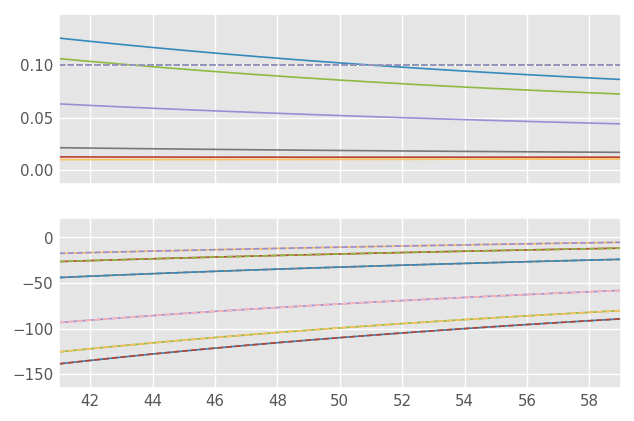

In [50]:
fix, (ax1, ax2) = plt.subplots(2,1, sharex=True)

# dummy transmission line to match port 3
coax = rf.media.Coaxial(frequency=capas_set[0].frequency)

for (ntw_name, ntw) in capas.items():
    ntw = rf.connect(ntw, 2, coax.match(), 0)
    Z = ntw.a[idx,0,1]
    (R,_,_), pcov = curve_fit(re_Z, omega[idx], np.real(Z))
    (_,C,L), pcov = curve_fit(im_Z, omega[idx], np.imag(Z))
    print(f'C={C:0.1f} pF, L={L:0.1f} nH, R={R:0.1e} Ohm')
    ax1.plot(f[idx]/1e6, np.real(Z))

    media = rf.media.DefinedGammaZ0(frequency=ntw.frequency, z0=50)
    ntw2 = media.capacitor(C*1e-12) ** media.inductor(L*1e-9) ** media.resistor(1e-1)
    
    ax1.plot(f[idx]/1e6, ntw2.a_re[idx,0,1], ls='--')
    
    ax2.plot(f[idx]/1e6, np.imag(Z))
    ax2.plot(f[idx]/1e6, ntw2.a_im[idx,0,1], ls='--')